<a href="https://colab.research.google.com/github/geoskimoto/Roaring-Springs-GRCA-Precipitation-Response-Analysis/blob/master/Causality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import functools as ft
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt 
from pathlib import Path
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from _plotly_future_ import v4_subplots
import plotly as pl
#import cufflinks as cf
#init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly import __version__
print(__version__)

4.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
root_pat= '/content/drive/My Drive/Colab Notebooks/RS_TracerStudy'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#Data Import and Munging

### Import Input Signal Data (Data recorded on Kaibab Plateau)

In [ ]:
PRISM_KPmean_precip = pd.read_csv('/content/drive/My Drive/Colab Notebooks/RS_TracerStudy/KP_weather_datafiles/PRISM_KPmean_precip.csv', index_col='system:time_start', parse_dates=True)
PRISM_KPmean_temp = pd.read_csv('/content/drive/My Drive/Colab Notebooks/RS_TracerStudy/KP_weather_datafiles/PRISM_KPmean_temp.csv', index_col='system:time_start', parse_dates=True)
MODIS_KPmean_EVT = pd.read_csv('/content/drive/My Drive/Colab Notebooks/RS_TracerStudy/KP_weather_datafiles/KP_mean_EVT.csv', index_col='system:time_start', parse_dates=True)

#Weather Station Input Signal File
BA_Station = pd.read_csv('/content/drive/My Drive/Colab Notebooks/RS_TracerStudy/KP_weather_datafiles/BA_StationData.csv', index_col='DATE', parse_dates=True)


### Import Output Signal Data (Discharge, Depth, and Water Temperature recorded in RS)

In [ ]:
RS_shallow_raw = pd.read_excel('/content/drive/My Drive/Colab Notebooks/RS_TracerStudy/RS_datafiles/RS_shallow.xlsx', index_col='Datetime', parse_dates=True)
RS_deep_raw = pd.read_excel('/content/drive/My Drive/Colab Notebooks/RS_TracerStudy/RS_datafiles/RS_LT500_Discharge_from_Rating_Curve.xlsx', index_col='Datetime', parse_dates=True)

In [ ]:
# Resample 15min data to daily means.  
RS_shallow_daily= RS_shallow_raw.resample(rule='D').mean()
RS_deep_daily = RS_deep_raw.resample(rule='D').mean()

In [ ]:
Shallow_Temp = RS_shallow_daily[['Temp(degC)']].copy()
Shallow_Depth = RS_shallow_daily[['Depth(ft)']].copy()
Deep_Discharge = RS_deep_daily[['Discharge ft^3/s']].copy()

In [ ]:
BA_Station.head(1)

,STATION,NAME,DAPR,MDPR,MDSF,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT05,WT06,WT11
DATE,,,,,,,,,,,,,,,,,
2010-01-01,USC00021001,"BRIGHT ANGEL RANGER STATION, AZ US",NaN,NaN,NaN,0.0,0.0,41.0,26.0,1.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
BA_Station.reset_index(inplace=True)
BA_Station['DATE'] = pd.to_datetime(BA_Station['DATE'])
BA_Station.rename(columns={'DATE':'Date'},inplace=True)
BA_Station.set_index('Date',inplace=True)

PRISM_KPmean_precip.reset_index(inplace=True)
PRISM_KPmean_precip['system:time_start']= pd.to_datetime(PRISM_KPmean_precip['system:time_start'])
PRISM_KPmean_precip.rename(columns={'system:time_start':'Date'}, inplace=True)
PRISM_KPmean_precip.set_index('Date',inplace=True)

PRISM_KPmean_temp.reset_index(inplace=True)
PRISM_KPmean_temp['system:time_start']= pd.to_datetime(PRISM_KPmean_temp['system:time_start'])
PRISM_KPmean_temp.rename(columns={'system:time_start':'Date'}, inplace=True)
PRISM_KPmean_temp.set_index('Date',inplace=True)

MODIS_KPmean_EVT.reset_index(inplace=True)
MODIS_KPmean_EVT['system:time_start']= pd.to_datetime(MODIS_KPmean_EVT['system:time_start'])
MODIS_KPmean_EVT.rename(columns={'system:time_start':'Date'}, inplace=True)
MODIS_KPmean_EVT.set_index('Date',inplace=True)

Deep_Discharge.reset_index(inplace=True)
Deep_Discharge['Datetime'] = pd.to_datetime(Deep_Discharge['Datetime'])
Deep_Discharge.rename(columns={'Datetime':'Date'}, inplace=True)
Deep_Discharge.set_index('Date', inplace=True)

Shallow_Temp.reset_index(inplace=True)
Shallow_Temp['Datetime'] = pd.to_datetime(Shallow_Temp['Datetime'])
Shallow_Temp.rename(columns={'Datetime':'Date'}, inplace=True)
Shallow_Temp.set_index('Date', inplace=True)

Shallow_Depth.reset_index(inplace=True)
Shallow_Depth['Datetime'] = pd.to_datetime(Shallow_Depth['Datetime'])
Shallow_Depth.rename(columns={'Datetime':'Date'}, inplace=True)
Shallow_Depth.set_index('Date', inplace=True)


In [ ]:
from functools import reduce

data_frames = [PRISM_KPmean_precip,PRISM_KPmean_temp,MODIS_KPmean_EVT, Deep_Discharge, Shallow_Depth, Shallow_Temp, BA_Station] #excluded shallow depth for now

df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True,
                                            how='outer'), data_frames)

In [ ]:
#dropping ET for now because the heatmap in the next cell shows that it's missing most of its data, so dropna will delete nearly everything.  Will need to fill
#these in if ET is to be used.

df_merged = df_merged.drop(['ET','MDSF','DAPR','MDPR','TOBS','WT01','WT03','WT04','WT05','WT06','WT11','STATION','NAME','PRCP','SNOW', 'TMIN','TMAX'], axis=1)
#Don't worry about dropping na's.  That will be done in granger function.

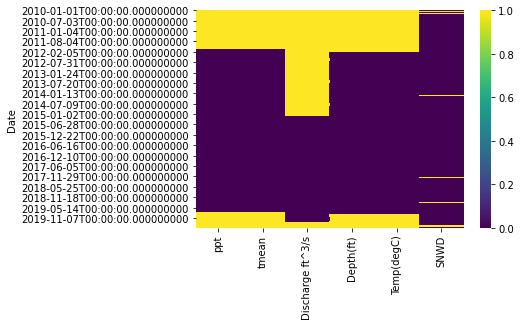

In [ ]:
sns.heatmap(df_merged.isnull(),cmap = 'viridis')

In [ ]:
df_merged2 = df_merged[1807:-265]
df_merged2 = df_merged2.fillna(method='pad')

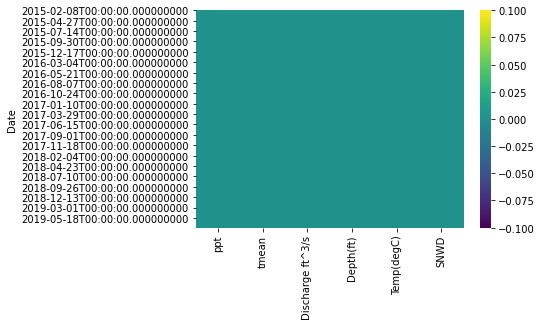

In [ ]:
sns.heatmap(df_merged2.isnull(),cmap = 'viridis')

In [ ]:
df_merged3 = df_merged2.reset_index().drop(['Date'], axis=1)
df_merged3 = df_merged3.dropna()

# Preliminary analysis to determine distribution, stationarity, and auto/partial correlation of data

### Checking distribution type for each data series

In [ ]:
stat, p = stats.normaltest(df_merged2['SNWD'])
alpha = 0.5
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Data does not look Gaussian (reject H0)


In [ ]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [ ]:
# import matplotlib.pyplot as plt
# import scipy
# import scipy.stats

# dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']

# for dist_name in dist_names:
#     dist = getattr(scipy.stats, dist_name)
#     param = dist.fit(y)
#     # here's the parameters of your distribution, scale, location

In [ ]:
df_merged2.head(1)

,ppt,tmean,Discharge ft^3/s,Depth(ft),Temp(degC),SNWD
Date,,,,,,
2015-02-08,0.0,10.073,5.710864,0.565545,11.008321,7.0


In [ ]:
get_best_distribution(df_merged2['SNWD'])

p value for norm = 6.370820375251701e-179
p value for exponweib = 0.0
p value for weibull_max = 1.2886398678245367e-231
p value for weibull_min = 0.0
p value for pareto = 0.0


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning:

invalid value encountered in double_scalars



p value for genextreme = 3.916621762434599e-200
Best fitting distribution: norm
Best p value: 6.370820375251701e-179
Parameters for the best fit: (7.412484700122399, 13.8875089237697)


('norm', 6.370820375251701e-179, (7.412484700122399, 13.8875089237697))

In [ ]:
stat, p = stats.normaltest(df_merged2['SNWD'])
p

1.3571633282782702e-129

In [ ]:
# def distribution_matrix(df, variables):
#   matrix = pd.DataFrame(np.zeros(len(variables)), columns=variables)
#   for c in matrix.column:
#     stat, p = stats.normaltest(df_merged2[df.columns[str(c)])
#     matrix.loc[c] = p
#   matrix.columns= [var for var in variables]
    
    
#     # if p > alpha:
#     # print('Data looks Gaussian (fail to reject H0)')
#     # else:
#     # print('Data does not look Gaussian (reject H0)')

### Checking ACF and PACF for each data series
https://www.youtube.com/watch?v=DeORzP0go5I

In [ ]:
# acf_plots = []
# pacf_plots = []
# for i in ['Depth(ft)', 'Temp(degC)', 'Discharge ft^3/s','ppt', 'tmean', 'SNWD']:
#   # fig, ax = plt.subplots(2, figsize=(10,6))
#   acf_plots.append(plot_acf(df_merged2[i],lags=50, title=i + ' ACF Plot'));
#   pacf_plots.append(plot_pacf(df_merged2[i], lags=50, title = i + ' PACF Plot'))
  
# #to read the PACF plots.  The bars that jump out at tn are direct and good predictors for t0.  
# #"The price of salmon x months ago is a good predictor of the price of salmon today"
# # So here, the PACF temp and discharge plots that show strong jumps at days 8 and 7, are good predictors of the current temp and discharge.  i.e. Discharge from 6 and 7 days ago is greatly (and positively) influencing todays discharge.

In [1]:
fig, ax = plt.subplots(2, figsize=(10,6))
ax[0]=plot_acf(df_merged2['Discharge ft^3/s'], ax=ax[0], lags=50)
ax[1]=plot_pacf(df_merged2['Discharge ft^3/s'], ax=ax[1], lags=50)

NameError: ignored

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



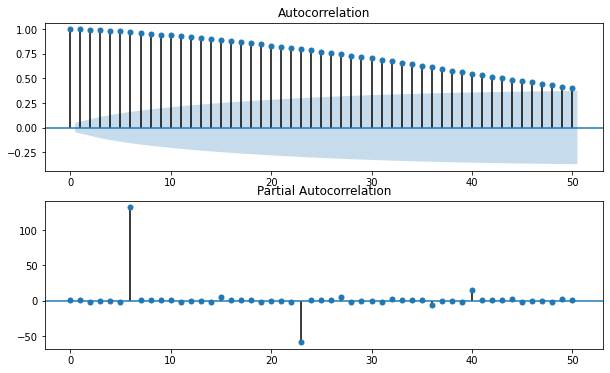

In [ ]:
fig, ax = plt.subplots(2, figsize=(10,6))
ax[0]=plot_acf(df_merged2['Temp(degC)'], ax=ax[0], lags=50)
ax[1]=plot_pacf(df_merged2['Temp(degC)'], ax=ax[1], lags=50)

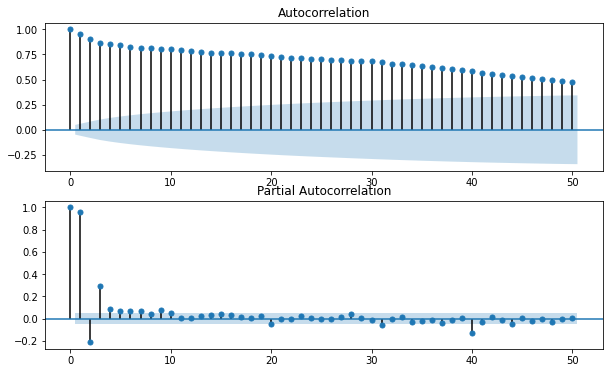

In [ ]:
fig, ax = plt.subplots(2, figsize=(10,6))
ax[0]=plot_acf(df_merged2['tmean'], ax=ax[0], lags=50)
ax[1]=plot_pacf(df_merged2['tmean'], ax=ax[1], lags=50)

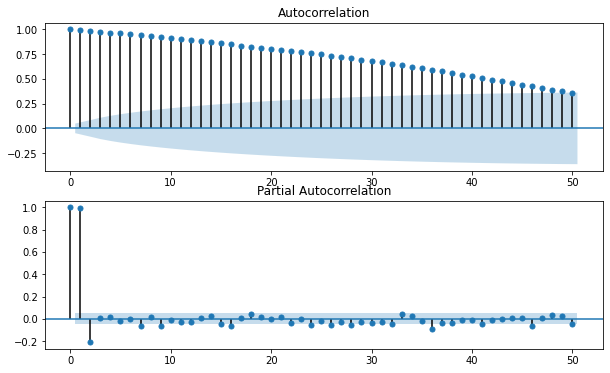

In [ ]:
fig, ax = plt.subplots(2, figsize=(10,6))
ax[0]=plot_acf(df_merged2['SNWD'], ax=ax[0], lags=50)
ax[1]=plot_pacf(df_merged2['SNWD'], ax=ax[1], lags=50)

### Checking stationarity for each data series

In [ ]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test_results =[]
for i in ['Depth(ft)','Temp(degC)','Discharge ft^3/s','ppt','tmean','SNWD']:
  adf_test_results.append(adf_test(df_merged2[i], title=i))

Augmented Dickey-Fuller Test: Depth(ft)
ADF test statistic        -4.179450
p-value                    0.000714
# lags used               24.000000
# observations          1609.000000
critical value (1%)       -3.434421
critical value (5%)       -2.863338
critical value (10%)      -2.567727
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augmented Dickey-Fuller Test: Temp(degC)
ADF test statistic        -4.324879
p-value                    0.000402
# lags used               25.000000
# observations          1608.000000
critical value (1%)       -3.434423
critical value (5%)       -2.863339
critical value (10%)      -2.567728
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augmented Dickey-Fuller Test: Discharge ft^3/s
ADF test statistic        -4.036974
p-value                    0.001229
# lags used               20.000000
# observations          1613.000000
cr

In [ ]:
# Granger Causality Test requires both series to be stationary.  All output signals (discharge, temp) are stationary and input signals (surface temp, precipitation) are.  
#SNWD is the only one that is not.  Might be because snow depth is recorded as 0 for much of the year and is throwing it off.  

### Snow depth is showing a unit root and is non-stationary.  Have to difference it and make it stationary for Granger Causality Test

### Determine collinearity between snowpack and surface temperatures

In [ ]:
# Need to determine dependency of snowpack and surface temps.  Perform collinearity, but also correlation and granger.

In [ ]:
df_merged2.head(1)

,ppt,tmean,Discharge ft^3/s,Depth(ft),Temp(degC),SNWD
Date,,,,,,
2015-02-08,0.0,10.073,5.710864,0.565545,11.008321,7.0


In [ ]:
df_merged2['tmean'].corr(df_merged2['SNWD'])

-0.5655274511986804

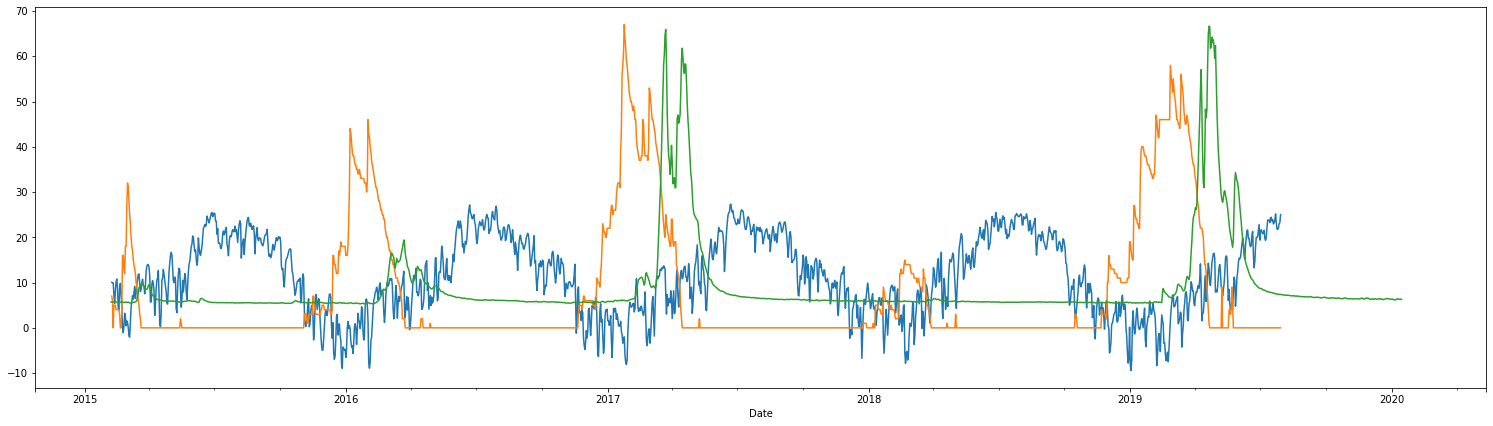

In [ ]:
fig, ax = plt.subplots(figsize=[26,7])
ax = df_merged2['tmean'].plot()
ax = df_merged2['SNWD'].plot()
ax = df_merged['Discharge ft^3/s'][1700:].plot()

In [ ]:
df_merged2.head(1)

,ppt,tmean,Discharge ft^3/s,Depth(ft),Temp(degC),SNWD
Date,,,,,,
2015-02-08,0.0,10.073,5.710864,0.565545,11.008321,7.0


In [ ]:
def corr_plot(start_date,stop_date, lag):
  fig, ax = plt.subplots(figsize=[20,4])
  ax = df_merged2['tmean'][start_date:stop_date].shift(lag).plot()
  ax = df_merged2['SNWD'][start_date:stop_date].plot()

  correlation = df_merged2['tmean'][start_date:stop_date].shit(lag).corr(df_merged2['SNWD'][start_date:stop_date])

  print(correlation)

In [ ]:
def corr_plot2(start_date,stop_date, lag, x, y):
  fig, ax = plt.subplots(figsize=[20,4])
  ax = df_merged2[y][start_date:stop_date].shift(lag).plot()
  ax = df_merged2[x][start_date:stop_date].plot()

  correlation = df_merged2[y][start_date:stop_date].shift(lag).corr(df_merged2[x][start_date:stop_date])

  print(correlation)

0.25756106639826953


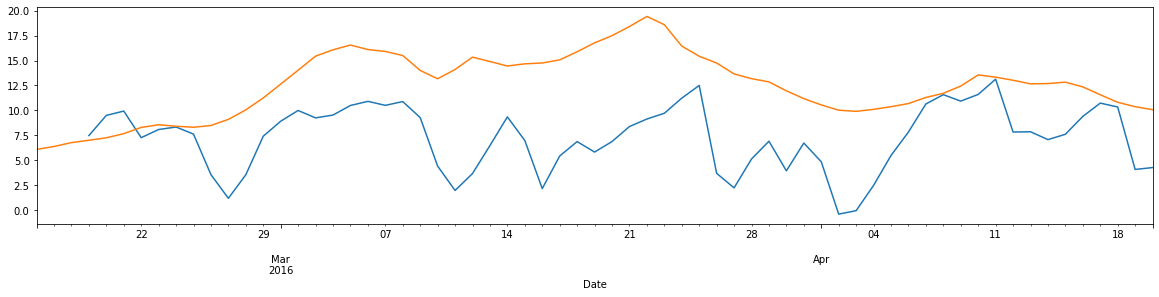

In [ ]:
corr_plot2('02-16-2016','04-20-2016',3,'Discharge ft^3/s', 'tmean')

0.6760845569910476


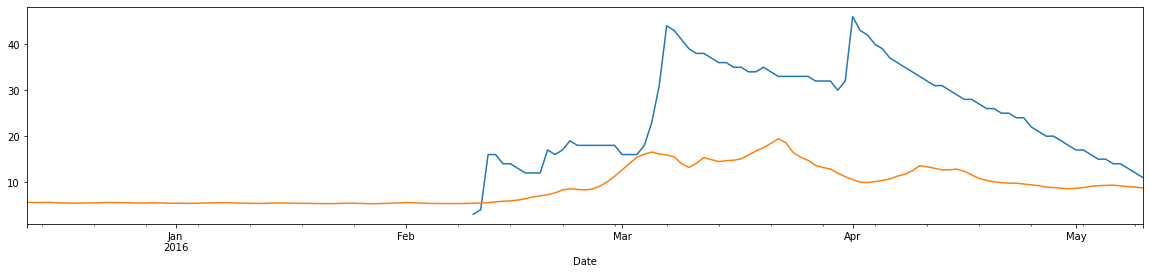

In [ ]:
corr_plot2('12-12-2015','05-10-2016',60,'Discharge ft^3/s', 'SNWD')

In [ ]:
CORRELATE SURFACE TEMPERATURE RANGE THAT CORRELATES WELL WITH DISCHARGE WITH THE SNOWPACK RANGE THAT CORRELATES WELL WITH DISCHARGE.  

-0.1978815600593286


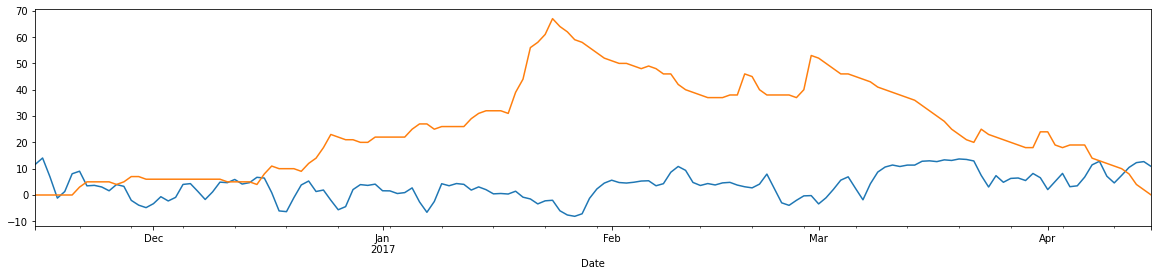

In [ ]:
corr_plot('11-15-2016','04-15-2017')

-0.09667270352533837


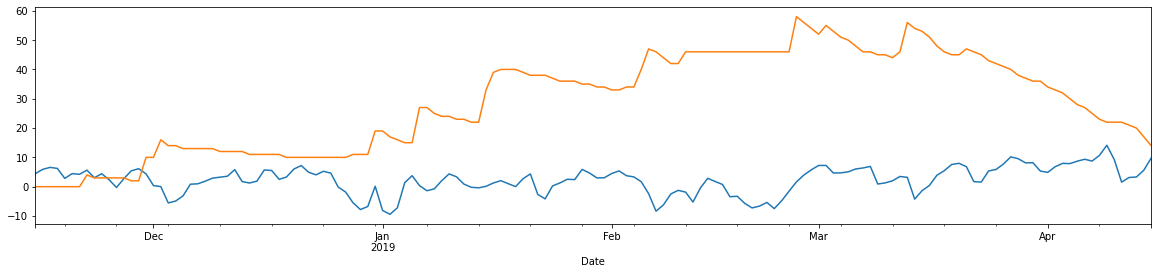

In [ ]:
corr_plot('11-15-2018','04-15-2019')

# Create class object for Granger Causality Analysis with two methods/functions:
*   Matrix of Ftest p value results between all input and output variables
*   Plot of the Ftest statistic and p values for the number of defined max lag





In [ ]:
class grangercausality():
    
       
    def __init__(self, start_date, stop_date, y_name, x_name, test, maxlag):
        self.start_date = start_date
        self.stop_date = stop_date
        self.y_name = y_name
        self.x_name = x_name
        self.test = test
        self.maxlag = maxlag
        

    def grangertest_plot(self, df):
        df[(df.Date >= self.start_date) & (df.Date <= self.stop_date)][self.y_name]
        df2 = pd.DataFrame(zip(df[self.y_name], df[self.x_name])).dropna()
        df2.columns = [self.y_name, self.x_name]


        gct = pd.DataFrame(grangercausalitytests(df2[[self.y_name,self.x_name]], maxlag=self.maxlag, verbose=False));

        Ftest = pd.DataFrame([gct[i][0][self.test][0] for i in list(range(1,self.maxlag+1))])
        Ftest.rename(columns={0:'Ftest stat'}, inplace=True)
        Ftest_pvalue = pd.DataFrame([gct[i][0]['ssr_ftest'][1] for i in list(range(1,self.maxlag+1))])
        Ftest_pvalue.rename(columns={0:'Ftest pvalue'}, inplace=True)

#         Ftest_dfd =  pd.DataFrame([gct[i][0][self.test][2] for i in list(range(1,self.maxlag+1))])
#         Ftest.rename(columns={0:'dfd'}, inplace=True)
#         Ftest_dfn =  pd.DataFrame([gct[i][0][self.test][3] for i in list(range(1,self.maxlag+1))])
#         Ftest.rename(columns={0:'dfn'}, inplace=True)

#         Ftable_values = pd.DataFrame(scipy.stats.f.ppf(q=.99, dfn=Ftest_dfn, dfd=Ftest_dfd))
#         Ftable_values.rename(columns={0:'F table value'}, inplace=True)

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=pd.DataFrame(list(Ftest.index)).iloc[:,0], y=Ftest['Ftest stat'], name='F test'))
        fig.add_trace(go.Scatter(x=pd.DataFrame(list(Ftest_pvalue.index)).iloc[:,0], y=Ftest_pvalue['Ftest pvalue'], name='F test pvalue'))    

        fig.show()



    def granger_matrix(self, df, variables, verbose=False):
        
        X_train = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
        for c in X_train.index:
            for r in X_train.index:
                test_result= grangercausalitytests(df[[r,c]], maxlag=self.maxlag,verbose=False)
                p_values=[round(test_result[i+1][0][self.test][1],4) for i in range(self.maxlag)]
                min_p_value = np.min(p_values)
                X_train.loc[r,c]=min_p_value
        X_train.columns = [var + '_x' for var in variables]
        X_train.index =[var + '_y' for var in variables]
        return X_train


# Run analysis on monsoon and snowmelt events:
*   M = monsoon event, SM = snowmelt event





In [ ]:
SM_Mar2017 = grangercausality( start_date='2017-03-01', stop_date='2017-04-15',y_name='Discharge ft^3/s',x_name='tmean', test='ssr_ftest',maxlag=45)

In [ ]:
SM_Mar2017.granger_matrix(df_merged3,variables=df_merged3.columns)

,ppt_x,tmean_x,Discharge ft^3/s_x,Depth(ft)_x,Temp(degC)_x,SNWD_x
ppt_y,1.0000,0.0055,0.2772,0.2564,0.0482,0.0
tmean_y,0.0000,1.0000,0.0000,0.0000,0.0173,0.0
Discharge ft^3/s_y,0.0039,0.0000,1.0000,0.0000,0.0000,0.0
Depth(ft)_y,0.0053,0.0000,0.0000,1.0000,0.0000,0.0
Temp(degC)_y,0.0008,0.0000,0.0000,0.0000,1.0000,0.0
SNWD_y,0.0037,0.0059,0.0000,0.0000,0.0000,1.0


In [ ]:
SM_Mar2017.grangertest_plot(df_merged2.reset_index())